In [3]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [4]:
style.set_style()

# load results from a directory

In [10]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/kernel_init/kernel_reps'
fnames = sorted([fname for fname in os.listdir(out_dir)])

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

results_list_w = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if fname.startswith('weights')]
results_w = pd.concat(results_list_w, axis=1).T.infer_objects()

100%|██████████| 72/72 [00:05<00:00,  5.69it/s]


**add cols**

In [11]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
its, ts, results = process_results(results)
print(results.shape)

(24, 82)


# check effect on test acc
*note some things disappear in below plot as a result of nans*

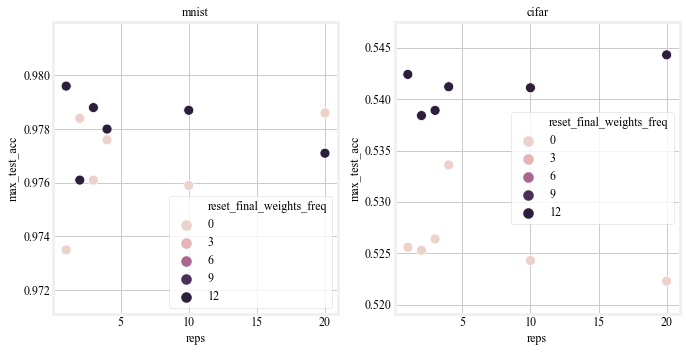

In [45]:
r = results
x = 'reps'
hue = 'reset_final_weights_freq'

plt.figure(figsize=(10, 5))
R, C = 1, 2
rm = r[r.dset == 'mnist']
plt.subplot(R, C, 1)
plt.title('mnist')
sns.scatterplot(rm[x], rm.max_test_acc, hue=rm[hue])

plt.subplot(R, C, 2)
rm = r[r.dset == 'cifar10']
plt.title('cifar')
sns.scatterplot(rm[x], rm.max_test_acc, hue=rm[hue])

plt.show()

# track things over time

In [8]:
from random import randint
cs = []

for i in range(25):
    cs.append('#%06X' % randint(0, 0xFFFFFF))
cs = sorted(cs)

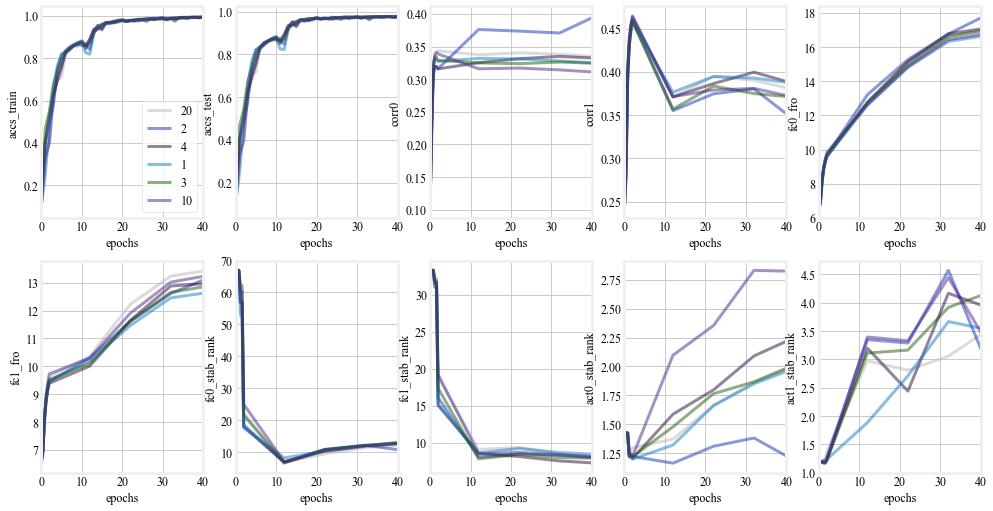

In [58]:
rm = results
rm = rm[rm.dset == 'mnist']
rm = rm[rm.reset_final_weights_freq == 10]

R, C = 2, 5
plt.figure(figsize=(15, 8))
xlim = 40

vals = ['accs_train', 'accs_test', 'corr0', 'corr1', 'fc0_fro', 'fc1_fro', 'fc0_stab_rank', 'fc1_stab_rank', 'act0_stab_rank', 'act1_stab_rank']

hue = 'reps'
# cs = {0: cb, 1: cr, 2: 'black', 3: 'green'}
# well-behaved
for _, row in rm.iterrows():

    for i, val in enumerate(vals):
        plt.subplot(R, C, i+1)
        try:
            plt.plot(ts, row[val], color=cs[row[hue]], alpha=0.5)
        except Exception as e:
#             print(e)
#             plt.plot(row.its[:row[val].size], row[val], color=cs[row[hue]], alpha=0.5, label=str(row[hue]))
            plt.plot(row[val], color=cs[row[hue]], alpha=0.5, label=str(row[hue]))    
        plt.xlabel('epochs')
        plt.ylabel(val)
        plt.xlim((0, xlim))
        
        if i == 0:
            plt.legend()

# look at an individual run

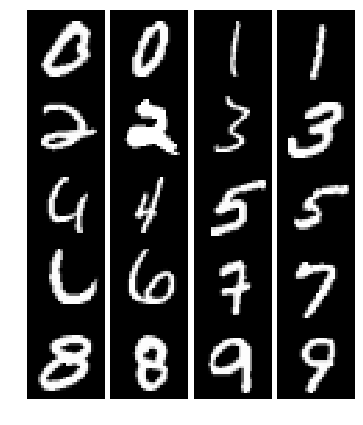

In [198]:
r = results
r = r[r.dset == 'mnist']
r = r[r.reps == 2]
run = r.iloc[0]
    
def plot_exs(run):
    exs = run.exs
    viz_weights.plot_weights(exs, dset=run.dset)
    plt.show()
# plot_exs(run)

In [173]:
print(run.dset, run.max_test_acc)

mnist 0.9761


In [174]:
# get processed data
epoch = int(max(ts))
run['num_layer'] = int(run['num_layers'])
run['hidden_size'] = int(run['hidden_size'])
run['batch_size'] = int(run.batch_size)
train_loader, test_loader = data.get_data_loaders(run)
X_train, Y_train, X_test, Y_test = data.process_loaders(train_loader, test_loader)

In [175]:
# get model
run = results_w[results_w.pid == run.pid].iloc[0]
run['reps'] = int(run['reps'])
model = data.get_model(run)
weights_dict_dict = run['weights'] # keys are epochs, vals are dicts of all weights
weights_dict = weights_dict_dict[epoch] # keys are layers, vals are weight values    
weights_dict_tensors = {k: torch.Tensor(v) for k, v in weights_dict.items()}
model.load_state_dict(weights_dict_tensors)
model = model.cuda()

In [188]:
# get raw images
import torchvision.datasets as dset
if 'cifar10' in run.dset:
    root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data/cifar10')
elif 'imagenet' in run.dset:
    root = '/scratch/users/vision/data/cv/imagenet_full'
else:
    root = oj('/scratch/users/vision/yu_dl/raaz.rsk/data/mnist')

if 'mnist' in run.dset:
    train_set = dset.MNIST(root=root, train=True, download=True)
    test_set = dset.MNIST(root=root, train=False, download=True)
elif 'cifar10' in run.dset:
    train_set = dset.CIFAR10(root=root, train=True, download=True)    
    test_set = dset.CIFAR10(root=root, train=False, download=True)
    
X_train_ims = train_set.train_data.detach().cpu().numpy()
Y_train_ims = train_set.train_labels    
X_test_ims = test_set.test_data.detach().cpu().numpy()
Y_test_ims = test_set.test_labels

In [189]:
print(X_train.shape, X_test.shape, X_train_ims.shape, X_test_ims.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28]) (60000, 28, 28) (10000, 28, 28)


In [190]:
preds = model.forward_no_pool(X_train).cpu().detach().numpy()

In [191]:
preds.shape

(60000, 20)

In [192]:
i0 = preds[:, 3].argsort()[::-1]

In [193]:
print(i0, np.max(i0), np.min(i0))

[32436 46184 15048 ... 13457 37143 12012] 59999 0


In [194]:
x = X_train_ims[i0]
# x = X_test_ims[i0]
# x = np.transpose(x, axes=(0, 2, 3, 1))

In [195]:
print(x.shape)

(60000, 28, 28)


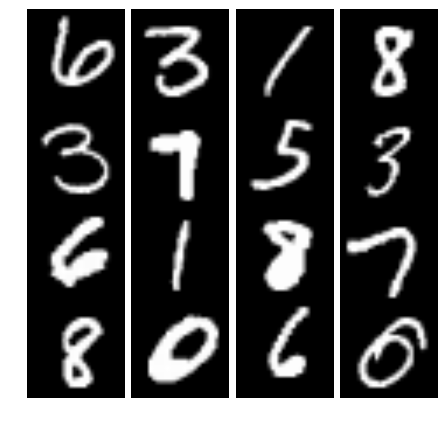

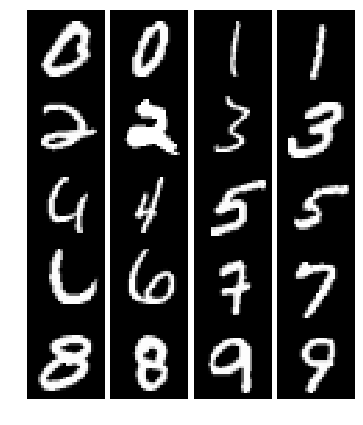

In [200]:
viz_weights.plot_weights(x[:16], dset=run.dset, interpolation='bilinear')
plot_exs(run)
# style.show(x[2])